In [1]:
import pandas as pd

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

from torchvision import transforms

from sklearn.model_selection import train_test_split
import math

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

# Logistic Regression (L1) - Regularization

In [91]:
df = pd.read_csv('CleanedData.csv')

In [92]:
# remove classes with only 1 example (MAG=6)
df['MAG'] = df['MAG'].astype(int)
df.groupby(by='MAG').count().rename(columns={'Unnamed: 0': 'Count of Rows'})#['Count of Rows']

,Count of Rows,#YYY/MM/DD,LAT,LON,DEPTH,Q
MAG,,,,,,
0,164905,164905,164905,164905,164905,164905
1,187056,187056,187056,187056,187056,187056
2,52225,52225,52225,52225,52225,52225
3,10119,10119,10119,10119,10119,10119
4,845,845,845,845,845,845
5,55,55,55,55,55,55
6,1,1,1,1,1,1


In [93]:
df = df[df['MAG'] != 6]
df.groupby(by='MAG').count()

,Unnamed: 0,#YYY/MM/DD,LAT,LON,DEPTH,Q
MAG,,,,,,
0,164905,164905,164905,164905,164905,164905
1,187056,187056,187056,187056,187056,187056
2,52225,52225,52225,52225,52225,52225
3,10119,10119,10119,10119,10119,10119
4,845,845,845,845,845,845
5,55,55,55,55,55,55


In [94]:
# one-hot encode quality "Q"
cols = ['Q']
one_hot_cols = df[cols] #.reshape(-1, 1)
enc = OneHotEncoder()
enc.fit(one_hot_cols)
encoded_cols = pd.DataFrame(enc.transform(one_hot_cols).toarray()
                            , columns=enc.get_feature_names_out())
encoded_cols.head()

,Q_A,Q_B,Q_C,Q_D,Q_Z
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [97]:
# add the newly encoded columns to the data and drop the original columns
df2 = df.join(encoded_cols).drop(cols,axis=1)
df2 = df2.fillna(0)
df2.head()
#for c in df2.columns:
#    print(c, df2[c].unique())

,Unnamed: 0,#YYY/MM/DD,MAG,LAT,LON,DEPTH,Q_A,Q_B,Q_C,Q_D,Q_Z
0,21,1980-01-02,2,32.445,-115.162,4.8,0.0,0.0,1.0,0.0,0.0
1,30,1980-01-02,3,34.449,-119.680,15.6,0.0,0.0,0.0,1.0,0.0
2,33,1980-01-02,2,33.040,-115.499,5.1,1.0,0.0,0.0,0.0,0.0
3,38,1980-01-03,2,32.967,-115.542,14.5,1.0,0.0,0.0,0.0,0.0
4,48,1980-01-03,2,33.943,-116.304,0.7,1.0,0.0,0.0,0.0,0.0


In [96]:
X = df2[['LAT', 'LON', 'DEPTH', 'Q_A', 'Q_B', 'Q_C', 'Q_D', 'Q_Z']]
y = df2['MAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
logistic = LogisticRegression(solver='liblinear',penalty='l1',C=1.0, random_state=1)
logistic.fit(X_train, y_train)
print("Done")

Done


c:\python38\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [98]:
coefficients = logistic.coef_
coefficients.shape

(6, 8)

In [99]:
i = 0
for c in X.columns:
  print(coefficients[2][i], '\t', c)
  i = i + 1

-0.2941458385007907 	 LAT
-0.016513208018584684 	 LON
-0.07348082207674606 	 DEPTH
3.1993663741376857 	 Q_A
3.6580773757278635 	 Q_B
3.786477004503291 	 Q_C
4.324821932018484 	 Q_D
0.0 	 Q_Z


# Extra Transformations for Neural Network

In [2]:
df = pd.read_csv('CleanedData.csv')
df.head()

print(df.describe())
print(df.info())

          Unnamed: 0            MAG            LAT            LON  \
count  415206.000000  415206.000000  415206.000000  415206.000000   
mean   586645.494675       1.283736      34.261559    -116.973450   
std    146368.176445       0.712565       1.209252       0.925457   
min        21.000000       0.000000      32.000000    -122.000000   
25%    483388.250000       0.770000      33.422000    -117.665000   
50%    597916.500000       1.160000      33.933000    -116.802000   
75%    706109.750000       1.660000      35.669000    -116.401000   
max    812791.000000       6.070000      37.000000    -114.233000   

               DEPTH  
count  415206.000000  
mean        7.632999  
std         4.688657  
min        -2.300000  
25%         3.900000  
50%         7.000000  
75%        10.900000  
max        58.100000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415206 entries, 0 to 415205
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --

## Group data for model

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df.drop('Q',axis=1,inplace=True)
df.head()

,#YYY/MM/DD,MAG,LAT,LON,DEPTH
0,1980-01-02,2.35,32.445,-115.162,4.8
1,1980-01-02,3.15,34.449,-119.680,15.6
2,1980-01-02,2.83,33.040,-115.499,5.1
3,1980-01-03,2.49,32.967,-115.542,14.5
4,1980-01-03,2.52,33.943,-116.304,0.7


In [4]:
# Calculate rolling mean MAG
def get_rolling_agg(df, method, days, col):
    if method == 'max':
        df2 = df.groupby(['#YYY/MM/DD'])[col].max()
        rolling = df2.rolling(days,min_periods=0)
        df2 = rolling.max()
    elif method == 'sum':
        df2 = df.groupby(['#YYY/MM/DD'])[col].sum()
        rolling = df2.rolling(days,min_periods=0)
        df2 = rolling.sum()
    elif method == 'std':
        df2 = df.groupby(['#YYY/MM/DD'])[col]
        rolling = df2.rolling(days,min_periods=0)
        df2 = rolling.std()
    df2 = df2.reset_index()
    df2['#YYY/MM/DD'] = pd.to_datetime(df2['#YYY/MM/DD']).dt.normalize()
    df2['Year'] = df2['#YYY/MM/DD'].dt.strftime("%Y")
    df2.drop('#YYY/MM/DD',axis=1,inplace=True)
    df2 = df2.groupby(['Year']).max()
    return df2

In [5]:
df2 = df.copy()
df2.loc[df2['MAG'] >= 5.5,'Count_L'] = 1
df2.loc[df2['MAG'] < 5.5,'Count_S'] = 1
df2[['Count_L','Count_S']] = df2[['Count_L','Count_S']].fillna(0)
df2.reset_index()

,index,#YYY/MM/DD,MAG,LAT,LON,DEPTH,Count_L,Count_S
0,0,1980-01-02,2.35,32.445,-115.162,4.8,0.0,1.0
1,1,1980-01-02,3.15,34.449,-119.680,15.6,0.0,1.0
2,2,1980-01-02,2.83,33.040,-115.499,5.1,0.0,1.0
3,3,1980-01-03,2.49,32.967,-115.542,14.5,0.0,1.0
4,4,1980-01-03,2.52,33.943,-116.304,0.7,0.0,1.0
...,...,...,...,...,...,...,...,...
415201,415201,2023-04-15,2.32,33.293,-117.823,58.1,0.0,1.0
415202,415202,2023-04-15,0.87,32.463,-116.804,1.2,0.0,1.0
415203,415203,2023-04-15,0.86,33.395,-116.896,13.9,0.0,1.0
415204,415204,2023-04-15,1.24,32.398,-116.239,20.1,0.0,1.0


In [6]:
df_1yrctL = get_rolling_agg(df2, 'sum', 365, 'Count_L')
df_1yrctS = get_rolling_agg(df2, 'sum', 365, 'Count_S')
df_combined = df_1yrctS.join(df_1yrctL,rsuffix="L")
df_combined.head()

,Count_S,Count_L
Year,,
1980,626.0,0.0
1981,892.0,1.0
1982,822.0,2.0
1983,965.0,4.0
1984,983.0,4.0


In [7]:
df_1yrmax = get_rolling_agg(df, 'max', 365, 'MAG')
df_5yrmax = get_rolling_agg(df, 'max', 365*5, 'MAG')
df_10yrmax = get_rolling_agg(df, 'max', 365*10, 'MAG')
df_5yrmax.head()

,MAG
Year,
1980,5.34
1981,5.75
1982,5.75
1983,6.07
1984,6.07


In [8]:
df_combined = df_combined.join(df_1yrmax,rsuffix="1yr")
df_combined = df_combined.join(df_5yrmax,rsuffix="5yr")
df_combined = df_combined.join(df_10yrmax,rsuffix="10yr")
df_combined.head()

,Count_S,Count_L,MAG,MAG5yr,MAG10yr
Year,,,,,
1980,626.0,0.0,5.34,5.34,5.34
1981,892.0,1.0,5.75,5.75,5.75
1982,822.0,2.0,5.75,5.75,5.75
1983,965.0,4.0,6.07,6.07,6.07
1984,983.0,4.0,6.07,6.07,6.07


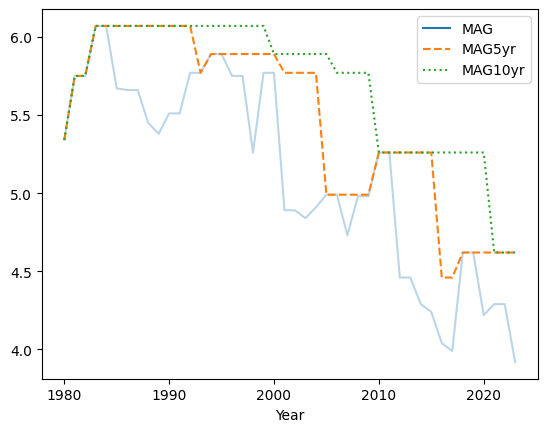

In [9]:
data = pd.DataFrame(df_combined[['MAG','MAG5yr','MAG10yr']])
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

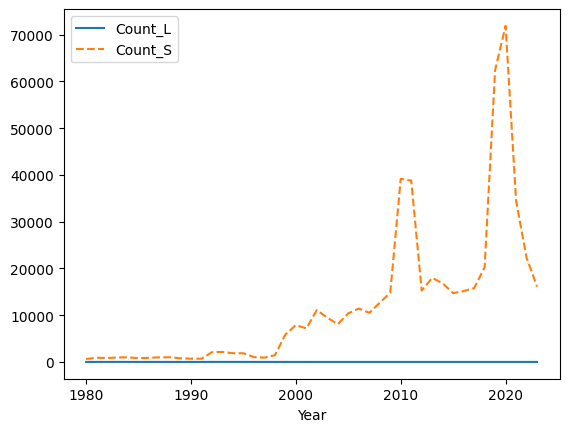

In [10]:
ax2 = df_combined[['Count_L','Count_S']].plot(style=['-', '--', ':'])

In [11]:
# Define the columns to be normalized
cols_to_norm = ['MAG','MAG5yr','MAG10yr','Count_L','Count_S']

# Get the orignal data
original_data = df_combined[cols_to_norm]

# Get the normalized data
normalized_data = (df_combined[cols_to_norm] - df_combined[cols_to_norm].min()) / (df_combined[cols_to_norm].max() - df_combined[cols_to_norm].min())

print("Original data headings:")
print(original_data.columns.tolist())
print("\nNormalized data headings:")
print(normalized_data.columns.tolist())

# Print the normalized data
print("\nNormalized data:")
print(normalized_data)

Original data headings:
['MAG', 'MAG5yr', 'MAG10yr', 'Count_L', 'Count_S']

Normalized data headings:
['MAG', 'MAG5yr', 'MAG10yr', 'Count_L', 'Count_S']

Normalized data:
           MAG    MAG5yr   MAG10yr  Count_L   Count_S
Year                                                 
1980  0.660465  0.546584  0.496552      0.0  0.000000
1981  0.851163  0.801242  0.779310      0.2  0.003733
1982  0.851163  0.801242  0.779310      0.4  0.002750
1983  1.000000  1.000000  1.000000      0.8  0.004757
1984  1.000000  1.000000  1.000000      0.8  0.005010
1985  0.813953  1.000000  1.000000      0.2  0.002400
1986  0.809302  1.000000  1.000000      0.2  0.003522
1987  0.809302  1.000000  1.000000      0.2  0.004982
1988  0.711628  1.000000  1.000000      0.0  0.005052
1989  0.679070  1.000000  1.000000      0.0  0.002091
1990  0.739535  1.000000  1.000000      0.2  0.000912
1991  0.739535  1.000000  1.000000      0.2  0.000870
1992  0.860465  1.000000  1.000000      1.0  0.020474
1993  0.860465  0.8

In [12]:
normalized_data.to_csv('TransformedData.csv')
print("Done")

Done


## Split Data for Model

- Rolling windows: 
https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html
- On using a torch DataLoader:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
not that useful. https://visualstudiomagazine.com/articles/2020/09/10/pytorch-dataloader.aspx

In [13]:
import torch
from torch.utils.data import TensorDataset, DataLoader

import time
import torch.nn as nn
import torch.optim as optim

In [14]:
df_combined= pd.read_csv('TransformedData.csv')
df_combined = df_combined.reset_index()
df_combined.head()

,index,Year,MAG,MAG5yr,MAG10yr,Count_L,Count_S
0,0,1980,0.660465,0.546584,0.496552,0.0,0.000000
1,1,1981,0.851163,0.801242,0.779310,0.2,0.003733
2,2,1982,0.851163,0.801242,0.779310,0.4,0.002750
3,3,1983,1.000000,1.000000,1.000000,0.8,0.004757
4,4,1984,1.000000,1.000000,1.000000,0.8,0.005010


In [50]:
def split_data(data, labels, batch_size):
    data.reset_index()
    labels.reset_index()

    x_train_val,x_test,y_train_val,y_test = train_test_split(data,labels,stratify=labels,test_size=0.20, random_state=42)
    x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,stratify=y_train_val,test_size=0.10, random_state=42)

    num_classes = len(y_test.unique())
    print(num_classes, y_test.unique())
    
    y_train = torch.tensor(y_train.values)
    y_val = torch.tensor(y_val.values)
    y_test = torch.tensor(y_test.values)

    train_dataset = TensorDataset(torch.tensor(x_train.to_numpy()).to(torch.float32),y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    val_dataset = TensorDataset(torch.tensor(x_val.to_numpy()).to(torch.float32),y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    test_dataset = TensorDataset(torch.tensor(x_test.to_numpy()).to(torch.float32),y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    #print(type(x_train_val),type(x_test),type(y_test))
    return test_loader, val_loader, train_loader, train_dataset, val_dataset, test_dataset, num_classes

In [23]:
# don't encode target class...
def encode_test(test):
    num_classes = len(test.unique())
    print(num_classes)

    test = torch.nn.functional.one_hot(torch.LongTensor(test.values))
    #y_test = (y_test - y_test.min())/(y_test.max() - y_test.min())

    #print(test)

    num_classes = test.shape[1]
    print(test.shape, num_classes)
    return test

#y_train = encode_test(y_train)
#y_val = encode_test(y_val)
#print(y_test.shape)
#y_test = encode_test(y_test)

In [24]:
def print_dataset2(dataset, name):
    print(name)
    
    x = pd.DataFrame(dataset.tensors[0])
    y = pd.DataFrame(dataset.tensors[1])
    
    print(x)
    print(y)

def print_dataset(dataset, name):
    print(name)
    
    x = dataset.tensors[0].numpy()
    y = dataset.tensors[1].numpy()
        
    for i in range(0, len(dataset)):
        row_x = '%s' % (x[i])
        row_y = "[%.04f]" % (y[i])
        
        row = "%s %s" % (row_x, row_y)
        print(row)
    print()



In [25]:
# helper function to plot final metrics
# tr_results: Training metrics DataFrame
# val_results: validation metrics DataFrame
# tst_results: testing metrics DataFrame
def plot_results(tr_results, val_results, tst_results):
    # create a new index from epochs and iterations
    
    # denominator (max # iterations)
    d = [tr_results[1].max() + 1
         , val_results[1].max() + 1
         , tst_results[1].max() + 1 ]
    
    i = 0
    for v in [tr_results, val_results, tst_results]:
        epoch = v[0]
        iteration = v[1]
        denominator = d[i]
        percent = (iteration / denominator)
        i = i + 1
        v['index'] = epoch + percent
        
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Training vs Validation')
    ax1.set_title("Loss")
    ax1.plot(tr_results['index'],tr_results[2],'-',label="training")
    ax1.plot(val_results['index'],val_results[2],'-',label="validation")
    ax1.legend()

    ax2.set_title("Accuracy")
    ax2.plot(tr_results['index'],tr_results[3],'-',label="training")
    ax2.plot(val_results['index'],val_results[3],'-',label="validation")
    ax2.legend()

    print("test accuracy %.3f" % max(tst_results[3]))

# Helper function to run the model and return calculated accuracy & loss for the given data
# Regardless of what data set it is (train, test, validation...)
def run_model(device, model, inputs, labels, train=False):    
    batch_size=inputs.size()[0]
    
    # send to GPU
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass
    logits = model(inputs)           #preds = model(inputs)
    
    # convert to formats accepted by CrossEntropyLoss
    logits = logits.float()
    labels = labels.long()
    
    # permute target to shape (batch_size, num_classes)
    
    #print(logits, labels)
    
    # calculate loss
    loss = criterion(logits, labels) #loss = criterion(preds, labels)
    
    # Backward pass and optimization
    if train==True:
        loss.backward()  # backward pass
        optimizer.step() # update weights
        
    # Compute accuracy
    probs = nn.functional.softmax(logits, dim=1)
    _, preds = torch.max(probs, 1)
    # predicted = torch.argmax(preds)  
    
    # Compute accuracy and loss
    correct = torch.sum(preds == labels) # correct = torch.sum(predicted == labels)
    acc = correct.double() / batch_size
    loss += loss.item()
    
    return (loss / 100), acc

# train, validdte, and test the model for X epochs in batches
def train_test_model_epochs(model, num_epochs=5):
    start_time = time.time()
    print("Start ", start_time)

    train_metrics = []
    valid_metrics = []
    test_metrics = []

    for epoch in range(num_epochs):
        train_acc = 0.0
        valid_acc = 0.0
        test_acc = 0.0

        running_loss = 0.0
        train_loss = 0.0
        valid_loss = 0.0
        test_loss = 0.0

        # Train model
        j = 0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            train_loss, train_acc = run_model(device, model, inputs, labels, train=True)
            train_loss = train_loss.item()
            train_acc  = train_acc.item()
            train_metrics.append( (epoch, i, train_loss, train_acc))
            j = i
        print(epoch, j, train_loss, train_acc)

        # change to evaluation mode
        model.eval()
        with torch.no_grad():
            
            # Validate model
            for i, (inputs, labels) in enumerate(train_loader, 0):
                valid_loss, valid_acc =  run_model(device, model, inputs, labels)
                valid_metrics.append( (epoch, i, valid_loss.item(), valid_acc.item()) )
            #print(epoch, 0, valid_loss, valid_acc)
            
            # Test model
            for i, (inputs, labels) in enumerate(train_loader, 0):
                test_loss, test_acc =  run_model(device, model, inputs, labels)
            test_metrics.append( (epoch, 0, test_loss, test_acc) )
            #print(epoch, test_loss, test_acc)
            
        # change back to training mode 
        model.train()

        print('[%d] loss/acc for train: (%.3f, %.3f), valid: (%.3f, %.3f), test: (%.3f, %.3f)' %
              (epoch + 1, train_loss, train_acc, \
               valid_loss, valid_acc, \
               test_loss, test_acc ))

    end_time = time.time()
    print("Done", end_time - start_time)
    
    return train_metrics, valid_metrics, test_metrics

In [43]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_variables, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
        self.layer1 = nn.Linear(input_variables, 5)
        self.layer2 = nn.Linear(5, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        
        # check 
        #print(x.shape, x.dtype, self.layer1.weight.dtype)
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        
        # perform softmax outside
        #x = self.softmax(self.layer1(x)) 
        return x

2 [0 1]
2
Start  1683924876.9559364
0 0 0.014218372292816639 0.3870967741935484
[1] loss/acc for train: (0.014, 0.387), valid: (0.014, 0.387), test: (0.014, 0.387)
1 0 0.01420355960726738 0.3870967741935484
[2] loss/acc for train: (0.014, 0.387), valid: (0.014, 0.387), test: (0.014, 0.387)
2 0 0.014188796281814575 0.3870967741935484
[3] loss/acc for train: (0.014, 0.387), valid: (0.014, 0.387), test: (0.014, 0.387)
3 0 0.0141740832477808 0.3870967741935484
[4] loss/acc for train: (0.014, 0.387), valid: (0.014, 0.387), test: (0.014, 0.387)
4 0 0.014159422367811203 0.3870967741935484
[5] loss/acc for train: (0.014, 0.387), valid: (0.014, 0.387), test: (0.014, 0.387)
5 0 0.014144813641905785 0.3870967741935484
[6] loss/acc for train: (0.014, 0.387), valid: (0.014, 0.387), test: (0.014, 0.387)
6 0 0.014130258932709694 0.3870967741935484
[7] loss/acc for train: (0.014, 0.387), valid: (0.014, 0.387), test: (0.014, 0.387)
7 0 0.014115756377577782 0.3870967741935484
[8] loss/acc for train: (0.

[167] loss/acc for train: (0.012, 0.710), valid: (0.012, 0.710), test: (0.012, 0.710)
167 0 0.012268717400729656 0.7096774193548387
[168] loss/acc for train: (0.012, 0.710), valid: (0.012, 0.710), test: (0.012, 0.710)
168 0 0.01225755363702774 0.7096774193548387
[169] loss/acc for train: (0.012, 0.710), valid: (0.012, 0.710), test: (0.012, 0.710)
169 0 0.012246314436197281 0.7096774193548387
[170] loss/acc for train: (0.012, 0.710), valid: (0.012, 0.710), test: (0.012, 0.710)
170 0 0.012234997935593128 0.7096774193548387
[171] loss/acc for train: (0.012, 0.710), valid: (0.012, 0.710), test: (0.012, 0.710)
171 0 0.012223627418279648 0.7096774193548387
[172] loss/acc for train: (0.012, 0.710), valid: (0.012, 0.710), test: (0.012, 0.710)
172 0 0.012212198227643967 0.7096774193548387
[173] loss/acc for train: (0.012, 0.710), valid: (0.012, 0.710), test: (0.012, 0.710)
173 0 0.012200694531202316 0.7096774193548387
[174] loss/acc for train: (0.012, 0.710), valid: (0.012, 0.710), test: (0.012

314 0 0.009849156253039837 0.8064516129032258
[315] loss/acc for train: (0.010, 0.806), valid: (0.010, 0.806), test: (0.010, 0.806)
315 0 0.009830176830291748 0.8064516129032258
[316] loss/acc for train: (0.010, 0.806), valid: (0.010, 0.806), test: (0.010, 0.806)
316 0 0.009811226278543472 0.8064516129032258
[317] loss/acc for train: (0.010, 0.806), valid: (0.010, 0.806), test: (0.010, 0.806)
317 0 0.009792281314730644 0.8064516129032258
[318] loss/acc for train: (0.010, 0.806), valid: (0.010, 0.806), test: (0.010, 0.806)
318 0 0.00977335125207901 0.8064516129032258
[319] loss/acc for train: (0.010, 0.806), valid: (0.010, 0.806), test: (0.010, 0.806)
319 0 0.009754473343491554 0.8064516129032258
[320] loss/acc for train: (0.010, 0.806), valid: (0.010, 0.806), test: (0.010, 0.806)
320 0 0.009735610336065292 0.8064516129032258
[321] loss/acc for train: (0.010, 0.806), valid: (0.010, 0.806), test: (0.010, 0.806)
321 0 0.009716756641864777 0.8064516129032258
[322] loss/acc for train: (0.01

469 0 0.007440507411956787 0.8709677419354839
[470] loss/acc for train: (0.007, 0.871), valid: (0.007, 0.871), test: (0.007, 0.871)
470 0 0.007429042831063271 0.8709677419354839
[471] loss/acc for train: (0.007, 0.871), valid: (0.007, 0.871), test: (0.007, 0.871)
471 0 0.00741762388497591 0.8709677419354839
[472] loss/acc for train: (0.007, 0.871), valid: (0.007, 0.871), test: (0.007, 0.871)
472 0 0.007406253833323717 0.8709677419354839
[473] loss/acc for train: (0.007, 0.871), valid: (0.007, 0.871), test: (0.007, 0.871)
473 0 0.00739492941647768 0.8709677419354839
[474] loss/acc for train: (0.007, 0.871), valid: (0.007, 0.871), test: (0.007, 0.871)
474 0 0.007383745163679123 0.8709677419354839
[475] loss/acc for train: (0.007, 0.871), valid: (0.007, 0.871), test: (0.007, 0.871)
475 0 0.007372609805315733 0.8709677419354839
[476] loss/acc for train: (0.007, 0.871), valid: (0.007, 0.871), test: (0.007, 0.871)
476 0 0.007361493073403835 0.8709677419354839
[477] loss/acc for train: (0.007

628 0 0.006085795350372791 0.8709677419354839
[629] loss/acc for train: (0.006, 0.871), valid: (0.006, 0.871), test: (0.006, 0.871)
629 0 0.006079444661736488 0.8709677419354839
[630] loss/acc for train: (0.006, 0.871), valid: (0.006, 0.871), test: (0.006, 0.871)
630 0 0.006073113065212965 0.8709677419354839
[631] loss/acc for train: (0.006, 0.871), valid: (0.006, 0.871), test: (0.006, 0.871)
631 0 0.006066799629479647 0.8709677419354839
[632] loss/acc for train: (0.006, 0.871), valid: (0.006, 0.871), test: (0.006, 0.871)
632 0 0.006060502957552671 0.8709677419354839
[633] loss/acc for train: (0.006, 0.871), valid: (0.006, 0.871), test: (0.006, 0.871)
633 0 0.0060542249120771885 0.8709677419354839
[634] loss/acc for train: (0.006, 0.871), valid: (0.006, 0.871), test: (0.006, 0.871)
634 0 0.006047963630408049 0.8709677419354839
[635] loss/acc for train: (0.006, 0.871), valid: (0.006, 0.871), test: (0.006, 0.871)
635 0 0.006041720975190401 0.8709677419354839
[636] loss/acc for train: (0.

[779] loss/acc for train: (0.005, 0.871), valid: (0.005, 0.871), test: (0.005, 0.871)
779 0 0.005302571691572666 0.8709677419354839
[780] loss/acc for train: (0.005, 0.871), valid: (0.005, 0.871), test: (0.005, 0.871)
780 0 0.005298408679664135 0.8709677419354839
[781] loss/acc for train: (0.005, 0.871), valid: (0.005, 0.871), test: (0.005, 0.871)
781 0 0.005294254049658775 0.8709677419354839
[782] loss/acc for train: (0.005, 0.871), valid: (0.005, 0.871), test: (0.005, 0.871)
782 0 0.005290105473250151 0.8709677419354839
[783] loss/acc for train: (0.005, 0.871), valid: (0.005, 0.871), test: (0.005, 0.871)
783 0 0.005285965744405985 0.8709677419354839
[784] loss/acc for train: (0.005, 0.871), valid: (0.005, 0.871), test: (0.005, 0.871)
784 0 0.005281832069158554 0.8709677419354839
[785] loss/acc for train: (0.005, 0.871), valid: (0.005, 0.871), test: (0.005, 0.871)
785 0 0.005277706775814295 0.8709677419354839
[786] loss/acc for train: (0.005, 0.871), valid: (0.005, 0.871), test: (0.00

935 0 0.004737893119454384 0.9032258064516129
[936] loss/acc for train: (0.005, 0.903), valid: (0.005, 0.903), test: (0.005, 0.903)
936 0 0.004734715912491083 0.9032258064516129
[937] loss/acc for train: (0.005, 0.903), valid: (0.005, 0.903), test: (0.005, 0.903)
937 0 0.004731541033834219 0.9032258064516129
[938] loss/acc for train: (0.005, 0.903), valid: (0.005, 0.903), test: (0.005, 0.903)
938 0 0.004728371277451515 0.9032258064516129
[939] loss/acc for train: (0.005, 0.903), valid: (0.005, 0.903), test: (0.005, 0.903)
939 0 0.00472520524635911 0.9032258064516129
[940] loss/acc for train: (0.005, 0.903), valid: (0.005, 0.903), test: (0.005, 0.903)
940 0 0.00472204340621829 0.9032258064516129
[941] loss/acc for train: (0.005, 0.903), valid: (0.005, 0.903), test: (0.005, 0.903)
941 0 0.004718884360045195 0.9032258064516129
[942] loss/acc for train: (0.005, 0.903), valid: (0.005, 0.903), test: (0.005, 0.903)
942 0 0.004715729970484972 0.9032258064516129
[943] loss/acc for train: (0.005

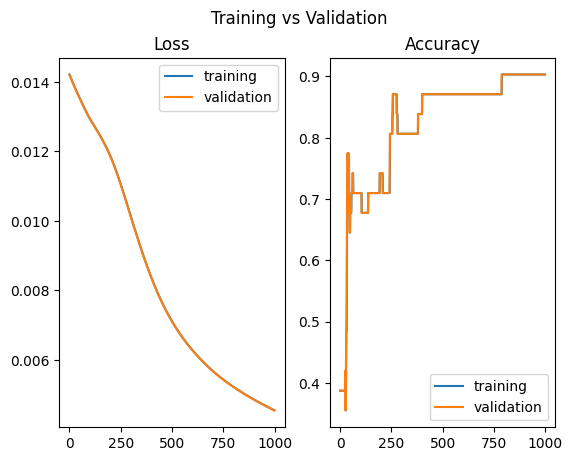

In [78]:
data = df_combined[['MAG','MAG5yr','Count_L','Count_S']]
labels = df_combined[['MAG10yr']]
labels = labels['MAG10yr'].astype(int)

batch_size = 35
test_loader, val_loader, train_loader, train_dataset, val_dataset, test_dataset, num_classes = split_data(data, labels, batch_size)

#print_dataset2(train_dataset, "Training Dataset")
#print_dataset2(val_dataset  , "Validation Dataset")
#print_dataset2(test_dataset , "Testing Dataset")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 1
input_dim = 256

# Instantiate model and define loss function and optimizer
print(num_classes)
model = NeuralNetwork(input_variables=4,num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

epochs=1000
train_metrics, val_metrics, test_metrics = train_test_model_epochs(model,num_epochs=epochs)

import matplotlib.pyplot as plt

plot_results( pd.DataFrame(train_metrics)
            , pd.DataFrame(val_metrics)
            , pd.DataFrame(test_metrics)
            )

In [76]:
print(num_classes)

1


1 [0]
1
Start  1683924820.362926
0 0 0.016292527318000793 0.06451612903225806
[1] loss/acc for train: (0.016, 0.065), valid: (0.016, 0.065), test: (0.016, 0.065)
1 0 0.016233177855610847 0.06451612903225806
[2] loss/acc for train: (0.016, 0.065), valid: (0.016, 0.065), test: (0.016, 0.065)
2 0 0.016174226999282837 0.06451612903225806
[3] loss/acc for train: (0.016, 0.065), valid: (0.016, 0.065), test: (0.016, 0.065)
3 0 0.01611568219959736 0.06451612903225806
[4] loss/acc for train: (0.016, 0.065), valid: (0.016, 0.065), test: (0.016, 0.065)
4 0 0.01605754718184471 0.06451612903225806
[5] loss/acc for train: (0.016, 0.065), valid: (0.016, 0.065), test: (0.016, 0.065)
5 0 0.01599982939660549 0.06451612903225806
[6] loss/acc for train: (0.016, 0.065), valid: (0.016, 0.065), test: (0.016, 0.065)
6 0 0.0159425288438797 0.06451612903225806
[7] loss/acc for train: (0.016, 0.065), valid: (0.016, 0.065), test: (0.016, 0.065)
7 0 0.015885651111602783 0.06451612903225806
[8] loss/acc for train: 

147 0 0.010726426728069782 0.9354838709677419
[148] loss/acc for train: (0.011, 0.935), valid: (0.011, 0.935), test: (0.011, 0.935)
148 0 0.010697170160710812 0.9354838709677419
[149] loss/acc for train: (0.011, 0.935), valid: (0.011, 0.935), test: (0.011, 0.935)
149 0 0.01066796574741602 0.9354838709677419
[150] loss/acc for train: (0.011, 0.935), valid: (0.011, 0.935), test: (0.011, 0.935)
150 0 0.010638811625540257 0.9354838709677419
[151] loss/acc for train: (0.011, 0.935), valid: (0.011, 0.935), test: (0.011, 0.935)
151 0 0.010609708726406097 0.9354838709677419
[152] loss/acc for train: (0.011, 0.935), valid: (0.011, 0.935), test: (0.011, 0.935)
152 0 0.010580657981336117 0.9354838709677419
[153] loss/acc for train: (0.011, 0.935), valid: (0.011, 0.935), test: (0.011, 0.935)
153 0 0.010551657527685165 0.9354838709677419
[154] loss/acc for train: (0.011, 0.935), valid: (0.011, 0.935), test: (0.011, 0.935)
154 0 0.010522712022066116 0.9354838709677419
[155] loss/acc for train: (0.01

[311] loss/acc for train: (0.007, 0.935), valid: (0.007, 0.935), test: (0.007, 0.935)
311 0 0.00705630611628294 0.9354838709677419
[312] loss/acc for train: (0.007, 0.935), valid: (0.007, 0.935), test: (0.007, 0.935)
312 0 0.007041884586215019 0.9354838709677419
[313] loss/acc for train: (0.007, 0.935), valid: (0.007, 0.935), test: (0.007, 0.935)
313 0 0.007027552928775549 0.9354838709677419
[314] loss/acc for train: (0.007, 0.935), valid: (0.007, 0.935), test: (0.007, 0.935)
314 0 0.007013310678303242 0.9354838709677419
[315] loss/acc for train: (0.007, 0.935), valid: (0.007, 0.935), test: (0.007, 0.935)
315 0 0.0069991606287658215 0.9354838709677419
[316] loss/acc for train: (0.007, 0.935), valid: (0.007, 0.935), test: (0.007, 0.935)
316 0 0.006985098589211702 0.9354838709677419
[317] loss/acc for train: (0.007, 0.935), valid: (0.007, 0.935), test: (0.007, 0.935)
317 0 0.006971125025302172 0.9354838709677419
[318] loss/acc for train: (0.007, 0.935), valid: (0.007, 0.935), test: (0.00

[467] loss/acc for train: (0.006, 0.935), valid: (0.006, 0.935), test: (0.006, 0.935)
467 0 0.005646846257150173 0.9354838709677419
[468] loss/acc for train: (0.006, 0.935), valid: (0.006, 0.935), test: (0.006, 0.935)
468 0 0.005641676019877195 0.9354838709677419
[469] loss/acc for train: (0.006, 0.935), valid: (0.006, 0.935), test: (0.006, 0.935)
469 0 0.005636536981910467 0.9354838709677419
[470] loss/acc for train: (0.006, 0.935), valid: (0.006, 0.935), test: (0.006, 0.935)
470 0 0.005631428211927414 0.9354838709677419
[471] loss/acc for train: (0.006, 0.935), valid: (0.006, 0.935), test: (0.006, 0.935)
471 0 0.005626352038234472 0.9354838709677419
[472] loss/acc for train: (0.006, 0.935), valid: (0.006, 0.935), test: (0.006, 0.935)
472 0 0.005621304735541344 0.9354838709677419
[473] loss/acc for train: (0.006, 0.935), valid: (0.006, 0.935), test: (0.006, 0.935)
473 0 0.005616285838186741 0.9354838709677419
[474] loss/acc for train: (0.006, 0.935), valid: (0.006, 0.935), test: (0.00

618 0 0.005088891368359327 0.9354838709677419
[619] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
619 0 0.005086028482764959 0.9354838709677419
[620] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
620 0 0.005083170719444752 0.9354838709677419
[621] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
621 0 0.00508031714707613 0.9354838709677419
[622] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
622 0 0.005077467765659094 0.9354838709677419
[623] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
623 0 0.005074622109532356 0.9354838709677419
[624] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
624 0 0.0050717806443572044 0.9354838709677419
[625] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
625 0 0.005068942904472351 0.9354838709677419
[626] loss/acc for train: (0.0

774 0 0.004650691524147987 0.9354838709677419
[775] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
775 0 0.004647728055715561 0.9354838709677419
[776] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
776 0 0.004644759465008974 0.9354838709677419
[777] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
777 0 0.004641787614673376 0.9354838709677419
[778] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
778 0 0.00463881203904748 0.9354838709677419
[779] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
779 0 0.00463583180680871 0.9354838709677419
[780] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
780 0 0.004632847849279642 0.9354838709677419
[781] loss/acc for train: (0.005, 0.935), valid: (0.005, 0.935), test: (0.005, 0.935)
781 0 0.004629860166460276 0.9354838709677419
[782] loss/acc for train: (0.005

[940] loss/acc for train: (0.004, 0.935), valid: (0.004, 0.935), test: (0.004, 0.935)
940 0 0.00410491181537509 0.9354838709677419
[941] loss/acc for train: (0.004, 0.935), valid: (0.004, 0.935), test: (0.004, 0.935)
941 0 0.004101346246898174 0.9354838709677419
[942] loss/acc for train: (0.004, 0.935), valid: (0.004, 0.935), test: (0.004, 0.935)
942 0 0.00409777881577611 0.9354838709677419
[943] loss/acc for train: (0.004, 0.935), valid: (0.004, 0.935), test: (0.004, 0.935)
943 0 0.004094208590686321 0.9354838709677419
[944] loss/acc for train: (0.004, 0.935), valid: (0.004, 0.935), test: (0.004, 0.935)
944 0 0.004090636502951384 0.9354838709677419
[945] loss/acc for train: (0.004, 0.935), valid: (0.004, 0.935), test: (0.004, 0.935)
945 0 0.004087062552571297 0.9354838709677419
[946] loss/acc for train: (0.004, 0.935), valid: (0.004, 0.935), test: (0.004, 0.935)
946 0 0.004083485342562199 0.9354838709677419
[947] loss/acc for train: (0.004, 0.935), valid: (0.004, 0.935), test: (0.004,

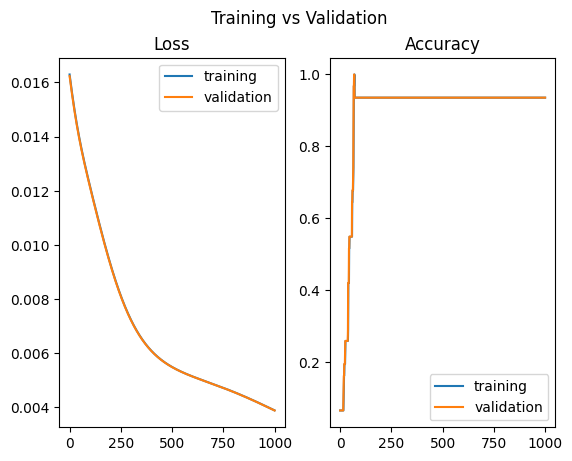

In [77]:
data = df_combined[['MAG5yr','MAG10yr','Count_L','Count_S']]
labels = df_combined[['MAG']]
labels = labels['MAG'].astype(int)

batch_size = 35
test_loader, val_loader, train_loader, train_dataset, val_dataset, test_dataset, num_classes = split_data(data, labels, batch_size)

#print_dataset2(train_dataset, "Training Dataset")
#print_dataset2(val_dataset  , "Validation Dataset")
#print_dataset2(test_dataset , "Testing Dataset")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 1
input_dim = 256

# Instantiate model and define loss function and optimizer
print(num_classes)
model = NeuralNetwork(input_variables=4,num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

epochs=1000
train_metrics, val_metrics, test_metrics = train_test_model_epochs(model,num_epochs=epochs)

import matplotlib.pyplot as plt

plot_results( pd.DataFrame(train_metrics)
            , pd.DataFrame(val_metrics)
            , pd.DataFrame(test_metrics)
            )

2 [0 1]
2
Start  1683924899.9601915
0 0 0.015445897355675697 0.22580645161290322
[1] loss/acc for train: (0.015, 0.226), valid: (0.015, 0.226), test: (0.015, 0.226)
1 0 0.015414243564009666 0.22580645161290322
[2] loss/acc for train: (0.015, 0.226), valid: (0.015, 0.226), test: (0.015, 0.226)
2 0 0.015382763929665089 0.22580645161290322
[3] loss/acc for train: (0.015, 0.226), valid: (0.015, 0.226), test: (0.015, 0.226)
3 0 0.015351450070738792 0.22580645161290322
[4] loss/acc for train: (0.015, 0.226), valid: (0.015, 0.226), test: (0.015, 0.226)
4 0 0.015320312231779099 0.22580645161290322
[5] loss/acc for train: (0.015, 0.226), valid: (0.015, 0.226), test: (0.015, 0.226)
5 0 0.015289343893527985 0.22580645161290322
[6] loss/acc for train: (0.015, 0.226), valid: (0.015, 0.226), test: (0.015, 0.226)
6 0 0.015258555300533772 0.22580645161290322
[7] loss/acc for train: (0.015, 0.226), valid: (0.015, 0.226), test: (0.015, 0.226)
7 0 0.01522794645279646 0.22580645161290322
[8] loss/acc for 

[167] loss/acc for train: (0.012, 0.774), valid: (0.012, 0.774), test: (0.012, 0.774)
167 0 0.011872401461005211 0.7741935483870968
[168] loss/acc for train: (0.012, 0.774), valid: (0.012, 0.774), test: (0.012, 0.774)
168 0 0.011856338940560818 0.7741935483870968
[169] loss/acc for train: (0.012, 0.774), valid: (0.012, 0.774), test: (0.012, 0.774)
169 0 0.011840462684631348 0.7741935483870968
[170] loss/acc for train: (0.012, 0.774), valid: (0.012, 0.774), test: (0.012, 0.774)
170 0 0.011824765242636204 0.7741935483870968
[171] loss/acc for train: (0.012, 0.774), valid: (0.012, 0.774), test: (0.012, 0.774)
171 0 0.011809243820607662 0.7741935483870968
[172] loss/acc for train: (0.012, 0.774), valid: (0.012, 0.774), test: (0.012, 0.774)
172 0 0.011793899349868298 0.7741935483870968
[173] loss/acc for train: (0.012, 0.774), valid: (0.012, 0.774), test: (0.012, 0.774)
173 0 0.011778725311160088 0.7741935483870968
[174] loss/acc for train: (0.012, 0.774), valid: (0.012, 0.774), test: (0.01

[325] loss/acc for train: (0.010, 0.774), valid: (0.010, 0.774), test: (0.010, 0.774)
325 0 0.010273393243551254 0.7741935483870968
[326] loss/acc for train: (0.010, 0.774), valid: (0.010, 0.774), test: (0.010, 0.774)
326 0 0.010266036726534367 0.7741935483870968
[327] loss/acc for train: (0.010, 0.774), valid: (0.010, 0.774), test: (0.010, 0.774)
327 0 0.010258556343615055 0.7741935483870968
[328] loss/acc for train: (0.010, 0.774), valid: (0.010, 0.774), test: (0.010, 0.774)
328 0 0.010251619853079319 0.7741935483870968
[329] loss/acc for train: (0.010, 0.774), valid: (0.010, 0.774), test: (0.010, 0.774)
329 0 0.010244559496641159 0.7741935483870968
[330] loss/acc for train: (0.010, 0.774), valid: (0.010, 0.774), test: (0.010, 0.774)
330 0 0.010237271897494793 0.7741935483870968
[331] loss/acc for train: (0.010, 0.774), valid: (0.010, 0.774), test: (0.010, 0.774)
331 0 0.010229784995317459 0.7741935483870968
[332] loss/acc for train: (0.010, 0.774), valid: (0.010, 0.774), test: (0.01

[476] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
476 0 0.009270780719816685 0.7741935483870968
[477] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
477 0 0.009264039807021618 0.7741935483870968
[478] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
478 0 0.009257097728550434 0.7741935483870968
[479] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
479 0 0.009252505376935005 0.7741935483870968
[480] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
480 0 0.009248215705156326 0.7741935483870968
[481] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
481 0 0.00924370065331459 0.7741935483870968
[482] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
482 0 0.009239313192665577 0.7741935483870968
[483] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009

[645] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
645 0 0.008585639297962189 0.7741935483870968
[646] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
646 0 0.008581753820180893 0.7741935483870968
[647] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
647 0 0.008578003384172916 0.7741935483870968
[648] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
648 0 0.008574139326810837 0.7741935483870968
[649] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
649 0 0.0085701709613204 0.7741935483870968
[650] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
650 0 0.008566582575440407 0.7741935483870968
[651] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009, 0.774)
651 0 0.008562625385820866 0.7741935483870968
[652] loss/acc for train: (0.009, 0.774), valid: (0.009, 0.774), test: (0.009,

793 0 0.008019736036658287 0.7741935483870968
[794] loss/acc for train: (0.008, 0.774), valid: (0.008, 0.774), test: (0.008, 0.774)
794 0 0.008015994913876057 0.7741935483870968
[795] loss/acc for train: (0.008, 0.774), valid: (0.008, 0.774), test: (0.008, 0.774)
795 0 0.008012267760932446 0.7741935483870968
[796] loss/acc for train: (0.008, 0.774), valid: (0.008, 0.774), test: (0.008, 0.774)
796 0 0.008008617907762527 0.7741935483870968
[797] loss/acc for train: (0.008, 0.774), valid: (0.008, 0.774), test: (0.008, 0.774)
797 0 0.008004793897271156 0.7741935483870968
[798] loss/acc for train: (0.008, 0.774), valid: (0.008, 0.774), test: (0.008, 0.774)
798 0 0.00800120085477829 0.7741935483870968
[799] loss/acc for train: (0.008, 0.774), valid: (0.008, 0.774), test: (0.008, 0.774)
799 0 0.007997366599738598 0.7741935483870968
[800] loss/acc for train: (0.008, 0.774), valid: (0.008, 0.774), test: (0.008, 0.774)
800 0 0.007993772625923157 0.7741935483870968
[801] loss/acc for train: (0.00

[950] loss/acc for train: (0.007, 0.839), valid: (0.007, 0.839), test: (0.007, 0.839)
950 0 0.007474098354578018 0.8387096774193549
[951] loss/acc for train: (0.007, 0.839), valid: (0.007, 0.839), test: (0.007, 0.839)
951 0 0.00747050391510129 0.8387096774193549
[952] loss/acc for train: (0.007, 0.839), valid: (0.007, 0.839), test: (0.007, 0.839)
952 0 0.007466938346624374 0.8387096774193549
[953] loss/acc for train: (0.007, 0.839), valid: (0.007, 0.839), test: (0.007, 0.839)
953 0 0.007463076151907444 0.8387096774193549
[954] loss/acc for train: (0.007, 0.839), valid: (0.007, 0.839), test: (0.007, 0.839)
954 0 0.007459250278770924 0.8387096774193549
[955] loss/acc for train: (0.007, 0.839), valid: (0.007, 0.839), test: (0.007, 0.839)
955 0 0.007455599959939718 0.8387096774193549
[956] loss/acc for train: (0.007, 0.839), valid: (0.007, 0.839), test: (0.007, 0.839)
956 0 0.007452643476426601 0.8387096774193549
[957] loss/acc for train: (0.007, 0.839), valid: (0.007, 0.839), test: (0.007

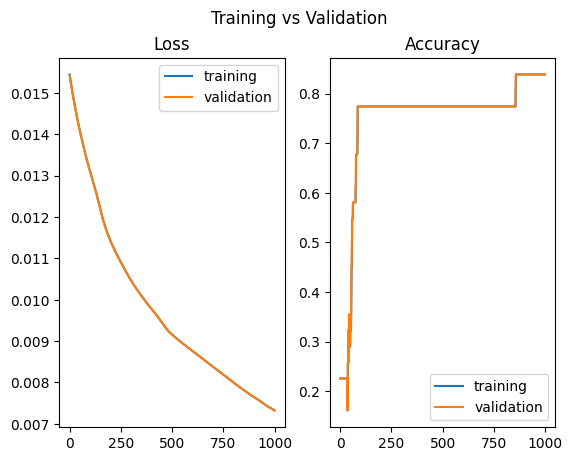

In [79]:
data = df_combined[['MAG','MAG10yr','Count_L','Count_S']]
labels = df_combined[['MAG5yr']]
labels = labels['MAG5yr'].astype(int)

batch_size = 35
test_loader, val_loader, train_loader, train_dataset, val_dataset, test_dataset, num_classes = split_data(data, labels, batch_size)

#print_dataset2(train_dataset, "Training Dataset")
#print_dataset2(val_dataset  , "Validation Dataset")
#print_dataset2(test_dataset , "Testing Dataset")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 1
input_dim = 256

# Instantiate model and define loss function and optimizer
print(num_classes)
model = NeuralNetwork(input_variables=4,num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

epochs=1000
train_metrics, val_metrics, test_metrics = train_test_model_epochs(model,num_epochs=epochs)

import matplotlib.pyplot as plt

plot_results( pd.DataFrame(train_metrics)
            , pd.DataFrame(val_metrics)
            , pd.DataFrame(test_metrics)
            )

array([[<AxesSubplot: title={'center': 'MAG10yr'}>]], dtype=object)

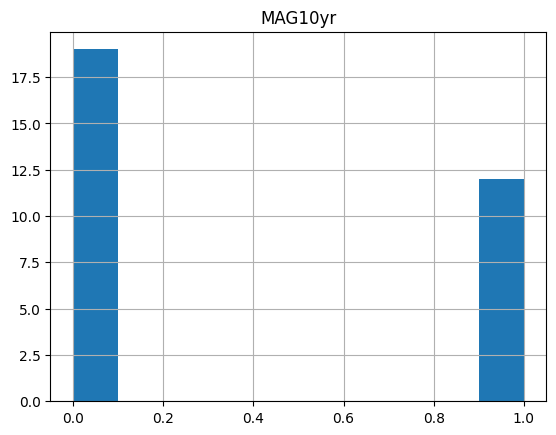

In [80]:
pd.DataFrame(y_train).hist()

In [81]:
print_dataset2(test_dataset , "Testing Dataset")

Testing Dataset
                0               1               2               3
0      tensor(0.)      tensor(0.)      tensor(0.)  tensor(0.2174)
1  tensor(0.8512)      tensor(1.)  tensor(0.2000)  tensor(0.0056)
2  tensor(0.3256)  tensor(0.4414)      tensor(0.)  tensor(0.2752)
3  tensor(0.8605)  tensor(0.8759)  tensor(0.2000)  tensor(0.1017)
4  tensor(0.4605)  tensor(0.8759)      tensor(0.)  tensor(0.1045)
5  tensor(0.8140)      tensor(1.)  tensor(0.2000)  tensor(0.0024)
6  tensor(0.8512)      tensor(1.)  tensor(0.2000)  tensor(0.0041)
7  tensor(0.8605)      tensor(1.)      tensor(1.)  tensor(0.0205)
8  tensor(0.6233)  tensor(0.4414)      tensor(0.)  tensor(0.5410)
   0
0  0
1  0
2  0
3  0
4  0
5  1
6  0
7  1
8  0


In [49]:
from sklearn.metrics import accuracy_score, f1_score

accuracy_score(y_test, y_test)
f1_score(y_test,y_test)

1.0